In [179]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim

In [180]:
ts = pd.read_csv("../data/processed/reports/combined.csv")
# Dodanie kolumny ret_1d_log dla całego DataFrame


ts

,symbol,date,open,high,low,close,volume,ret_1d,flag_abnormal_gap
0,acp,2015-01-02,30.0026,30.3974,29.6386,29.6386,106754,NaN,0
1,acp,2015-01-05,29.5031,29.9623,29.2865,29.8381,158005,0.006731,0
2,acp,2015-01-07,29.9032,31.1305,29.4090,30.9780,181319,0.038203,0
3,acp,2015-01-08,30.9592,31.7240,30.6484,31.6640,240391,0.022145,0
4,acp,2015-01-09,31.6066,31.6066,30.9190,31.1956,96704,-0.014793,0
...,...,...,...,...,...,...,...,...,...
37992,tpe,2025-11-03,10.0300,10.1200,9.8220,9.9000,1498322,-0.010000,0
37993,tpe,2025-11-04,9.9000,10.1200,9.8360,10.1000,1698516,0.020202,0
37994,tpe,2025-11-05,10.0850,10.5600,9.9900,10.4600,4709271,0.035644,0
37995,tpe,2025-11-06,10.4600,10.6200,10.1600,10.5700,4061709,0.010516,0


In [ ]:
# Rozdzielenie na szereg czasowy dla każdego symbolu
required_columns = ['date', 'open', 'high', 'low', 'close', 'volume', 'ret_1d',
'flag_abnormal_gap']

# Usunięcie kolumn bez nazwy (np. "Unnamed")
ts = ts.loc[:, ~ts.columns.str.contains('^Unnamed')]

# Filtracja danych, aby zawierały tylko wymagane kolumny
filtered_ts = ts[[col for col in required_columns if col in ts.columns] + ['symbol']]

# Grupowanie po symbolu i tworzenie słownika
time_series_dict = {}
for symbol, group in filtered_ts.groupby('symbol'):
    # Sortowanie danych w grupie po dacie (jeśli nie są posortowane)
    group = group.sort_values(by='date')

    # Dodanie kolumn specyficznych dla każdej spółki
    group['ret_1d_log'] = np.log(1 + group['ret_1d'])
    for lag in range(1, 5):  # Tworzenie lagów od 1 do 10
        group[f'ireturn_lag{lag}'] = group['ret_1d'].shift(lag)
        group[f'log_return_lag{lag}'] = group['ret_1d_log'].shift(lag)

    group = group.dropna()


    # Przechowywanie przetworzonej grupy w słowniku
    time_series_dict[symbol] = group


time_series_dict["acp"]


,date,open,high,low,close,volume,ret_1d,flag_abnormal_gap,symbol,ret_1d_log,...,ireturn_lag6,log_return_lag6,ireturn_lag7,log_return_lag7,ireturn_lag8,log_return_lag8,ireturn_lag9,log_return_lag9,ireturn_lag10,log_return_lag10
11,2015-01-20,30.6680,31.9004,30.6680,31.5184,219791,0.019983,0,acp,0.019786,...,-0.005655,-0.005671,-0.014793,-0.014903,0.022145,0.021903,0.038203,0.037491,0.006731,0.006709
12,2015-01-21,31.5184,31.6187,30.8487,31.1254,167006,-0.012469,0,acp,-0.012547,...,0.032222,0.031714,-0.005655,-0.005671,-0.014793,-0.014903,0.022145,0.021903,0.038203,0.037491
13,2015-01-22,31.6889,31.7240,31.2067,31.7240,145133,0.019232,0,acp,0.019049,...,-0.018002,-0.018166,0.032222,0.031714,-0.005655,-0.005671,-0.014793,-0.014903,0.022145,0.021903
14,2015-01-23,31.7240,31.9887,31.5776,31.6066,157034,-0.003701,0,acp,-0.003708,...,0.000922,0.000922,-0.018002,-0.018166,0.032222,0.031714,-0.005655,-0.005671,-0.014793,-0.014903
15,2015-01-26,31.7240,31.7240,30.9318,31.3130,239202,-0.009289,0,acp,-0.009333,...,-0.003130,-0.003135,0.000922,0.000922,-0.018002,-0.018166,0.032222,0.031714,-0.005655,-0.005671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2711,2025-11-03,215.6000,218.6000,214.2000,217.2000,81410,0.011173,0,acp,0.011111,...,0.015625,0.015504,-0.015385,-0.015504,0.010055,0.010005,-0.026690,-0.027053,0.048507,0.047368
2712,2025-11-04,217.0000,217.0000,209.0000,211.8000,77888,-0.024862,0,acp,-0.025176,...,0.025339,0.025024,0.015625,0.015504,-0.015385,-0.015504,0.010055,0.010005,-0.026690,-0.027053
2713,2025-11-05,210.0000,211.2000,204.6000,211.2000,156582,-0.002833,0,acp,-0.002837,...,0.021183,0.020961,0.025339,0.025024,0.015625,0.015504,-0.015385,-0.015504,0.010055,0.010005
2714,2025-11-06,207.6000,207.6000,195.1000,199.9000,232424,-0.053504,0,acp,-0.054988,...,-0.001729,-0.001730,0.021183,0.020961,0.025339,0.025024,0.015625,0.015504,-0.015385,-0.015504


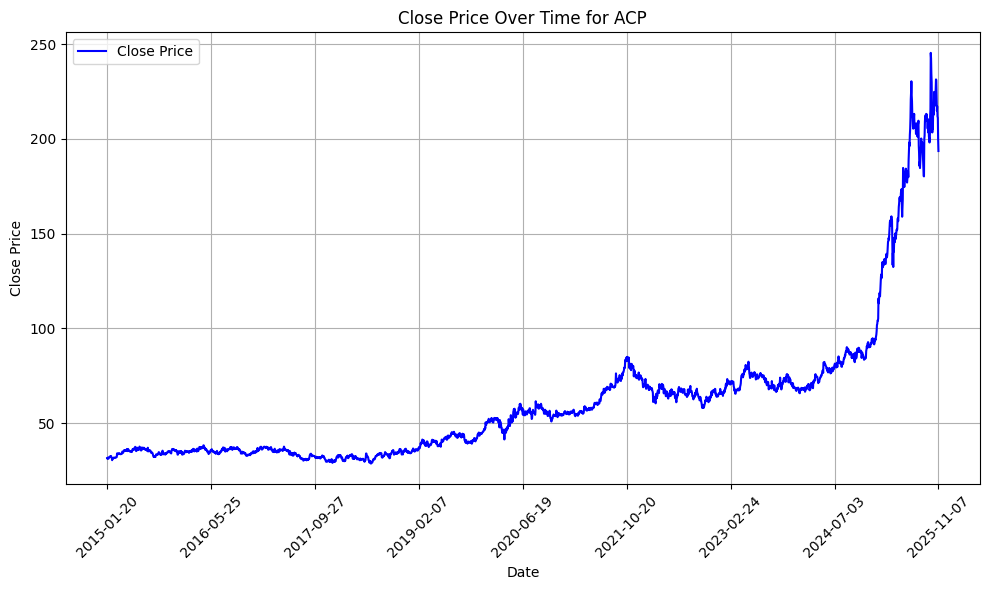

In [182]:
pkn_data = time_series_dict["acp"]

# Wykres wartości 'close' w czasie
plt.figure(figsize=(10, 6))
plt.plot(pkn_data['date'], pkn_data['close'], label='Close Price', color='blue')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Close Price Over Time for ACP')
plt.legend()
plt.grid(True)

# Wyświetlanie etykiet co 1/8 danych
num_labels = len(pkn_data['date'])
step = max(1, num_labels // 8)  # Co 1/8 danych
plt.xticks(ticks=pkn_data['date'][::step], labels=pkn_data['date'][::step], rotation=45)

plt.tight_layout()
plt.show()

In [238]:
class LinearModel(nn.Module):
    def __init__(self, input_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_features, 1)

    def forward(self, x):
        return self.linear(x)


class NonLinearModel(nn.Module):
    def __init__(self, input_features, hidden_size=64):
        super(NonLinearModel, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_features, hidden_size),
            nn.ReLU(),  # Non-linear activation
            nn.Linear(hidden_size , 1)  # Output layer
        )

    def forward(self, x):
        return self.network(x)

class AdvancedModel(nn.Module):
    def __init__(self, input_features, hidden_sizes=[16, 32, 16], dropout_rate=0.3):
        super(AdvancedModel, self).__init__()
        layers = []
        in_features = input_features

        # Tworzenie warstw ukrytych
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(in_features, hidden_size))
            layers.append(nn.LeakyReLU())  # LeakyReLU jako funkcja aktywacji
            layers.append(nn.Dropout(dropout_rate))  # Dropout dla regularizacji
            in_features = hidden_size

        # Warstwa wyjściowa
        layers.append(nn.Linear(in_features, 1))  # Wyjście: jedna wartość

        # Definiowanie sieci
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)


class LSTMModel(nn.Module):
    def __init__(self, input_features, hidden_size=64, num_layers=2, dropout=0.3):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Warstwa LSTM
        self.lstm = nn.LSTM(input_features, hidden_size, num_layers, batch_first=True, dropout=dropout)

        # Warstwa w pełni połączona (wyjściowa)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        # Inicjalizacja stanów ukrytych i komórkowych
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)  # Stan ukryty
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)  # Stan komórkowy

        # Przepływ przez LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Przepływ przez warstwę w pełni połączoną (tylko ostatni krok czasowy)
        out = self.fc(out[:, -1, :])  # Używamy tylko ostatniego kroku czasowego
        return out

In [211]:
features = [f'log_return_lag{lag}' for lag in range(1, 5)]
target = 'ret_1d_log'
test_size = 0.25

In [212]:

len(time_series_dict["acp"])

int(len(time_series_dict["acp"]) * test_size)



split_idx = int(len(time_series_dict["acp"]) * (1-test_size))
split_idx

2028

In [213]:

ts_train, ts_test = time_series_dict["acp"][:split_idx], time_series_dict["acp"][split_idx:]
ts_train = ts_train.dropna(subset=features + [target])
ts_test = ts_test.dropna(subset=features + [target])


ts_train

,date,open,high,low,close,volume,ret_1d,flag_abnormal_gap,symbol,ret_1d_log,...,ireturn_lag6,log_return_lag6,ireturn_lag7,log_return_lag7,ireturn_lag8,log_return_lag8,ireturn_lag9,log_return_lag9,ireturn_lag10,log_return_lag10
11,2015-01-20,30.6680,31.9004,30.6680,31.5184,219791,0.019983,0,acp,0.019786,...,-0.005655,-0.005671,-0.014793,-0.014903,0.022145,0.021903,0.038203,0.037491,0.006731,0.006709
12,2015-01-21,31.5184,31.6187,30.8487,31.1254,167006,-0.012469,0,acp,-0.012547,...,0.032222,0.031714,-0.005655,-0.005671,-0.014793,-0.014903,0.022145,0.021903,0.038203,0.037491
13,2015-01-22,31.6889,31.7240,31.2067,31.7240,145133,0.019232,0,acp,0.019049,...,-0.018002,-0.018166,0.032222,0.031714,-0.005655,-0.005671,-0.014793,-0.014903,0.022145,0.021903
14,2015-01-23,31.7240,31.9887,31.5776,31.6066,157034,-0.003701,0,acp,-0.003708,...,0.000922,0.000922,-0.018002,-0.018166,0.032222,0.031714,-0.005655,-0.005671,-0.014793,-0.014903
15,2015-01-26,31.7240,31.7240,30.9318,31.3130,239202,-0.009289,0,acp,-0.009333,...,-0.003130,-0.003135,0.000922,0.000922,-0.018002,-0.018166,0.032222,0.031714,-0.005655,-0.005671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2034,2023-02-17,72.2139,72.2139,71.3169,71.5411,41984,-0.009317,0,acp,-0.009360,...,0.044785,0.043811,-0.000640,-0.000640,0.011644,0.011576,-0.021519,-0.021754,0.010876,0.010818
2035,2023-02-20,71.7654,71.8551,70.6890,71.0926,38192,-0.006269,0,acp,-0.006289,...,-0.036129,-0.036798,0.044785,0.043811,-0.000640,-0.000640,0.011644,0.011576,-0.021519,-0.021754
2036,2023-02-21,71.0926,71.2720,69.6573,70.6890,49957,-0.005677,0,acp,-0.005693,...,0.010800,0.010742,-0.036129,-0.036798,0.044785,0.043811,-0.000640,-0.000640,0.011644,0.011576
2037,2023-02-22,70.8683,70.8683,69.8815,70.4198,47862,-0.003808,0,acp,-0.003816,...,-0.005657,-0.005673,0.010800,0.010742,-0.036129,-0.036798,0.044785,0.043811,-0.000640,-0.000640


In [214]:
X_train = torch.tensor(ts_train[features].to_numpy(), dtype=torch.float32)
X_test = torch.tensor(ts_test[features].to_numpy(), dtype=torch.float32)
y_train = torch.tensor(ts_train[target].to_numpy(), dtype=torch.float32)
y_test = torch.tensor(ts_test[target].to_numpy(), dtype=torch.float32)

In [215]:
X_train


tensor([[-0.0152, -0.0031,  0.0009, -0.0182],
        [ 0.0198, -0.0152, -0.0031,  0.0009],
        [-0.0125,  0.0198, -0.0152, -0.0031],
        ...,
        [-0.0063, -0.0094,  0.0000,  0.0175],
        [-0.0057, -0.0063, -0.0094,  0.0000],
        [-0.0038, -0.0057, -0.0063, -0.0094]])

In [216]:
y_train = y_train.reshape(-1, 1)

y_test = y_test.reshape(-1, 1)
y_train

tensor([[ 0.0198],
        [-0.0125],
        [ 0.0190],
        ...,
        [-0.0057],
        [-0.0038],
        [-0.0006]])

In [258]:
input_features = X_train.shape[1]  # Liczba cech wejściowych
model = LinearModel(input_features)

# Definicja funkcji kosztu i optymalizatora
criterion = nn.MSELoss()  # Funkcja kosztu: średni błąd kwadratowy
optimizer = optim.Adam(model.parameters(), lr=0.0005)  # Optymalizator: Adam

# Parametry treningu
num_epochs = 400  # Liczba epok
batch_size = 64  # Rozmiar batcha

# Funkcja do dzielenia danych na batch'e
def create_batches(X, y, batch_size):
    for i in range(0, len(X), batch_size):
        yield X[i:i + batch_size], y[i:i + batch_size]

# Trening modelu
for epoch in range(num_epochs):
    model.train()  # Tryb treningowy
    epoch_loss = 0.0

    # Tworzenie batch'y
    for X_batch, y_batch in create_batches(X_train, y_train, batch_size):
        optimizer.zero_grad()  # Wyzerowanie gradientów
        outputs = model(X_batch)  # Przewidywania modelu
        loss = criterion(outputs, y_batch)  # Obliczenie straty
        loss.backward()  # Propagacja wsteczna
        optimizer.step()  # Aktualizacja wag
        epoch_loss += loss.item()

    # Wyświetlanie straty co 10 epok
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# Testowanie modelu
model.eval()  # Tryb ewaluacji
with torch.no_grad():
    y_pred = model(X_test)  # Przewidywania na zbiorze testowym
    test_loss = criterion(y_pred, y_test)  # Obliczenie straty na zbiorze testowym

print(f"Test Loss: {test_loss.item():.4f}")

Epoch [10/400], Loss: 1.3902
Epoch [20/400], Loss: 0.3624
Epoch [30/400], Loss: 0.0707
Epoch [40/400], Loss: 0.0171
Epoch [50/400], Loss: 0.0107
Epoch [60/400], Loss: 0.0099
Epoch [40/400], Loss: 0.0171
Epoch [50/400], Loss: 0.0107
Epoch [60/400], Loss: 0.0099
Epoch [70/400], Loss: 0.0096
Epoch [80/400], Loss: 0.0094
Epoch [90/400], Loss: 0.0093
Epoch [70/400], Loss: 0.0096
Epoch [80/400], Loss: 0.0094
Epoch [90/400], Loss: 0.0093
Epoch [100/400], Loss: 0.0092
Epoch [110/400], Loss: 0.0092
Epoch [120/400], Loss: 0.0092
Epoch [100/400], Loss: 0.0092
Epoch [110/400], Loss: 0.0092
Epoch [120/400], Loss: 0.0092
Epoch [130/400], Loss: 0.0092
Epoch [140/400], Loss: 0.0092
Epoch [150/400], Loss: 0.0092
Epoch [130/400], Loss: 0.0092
Epoch [140/400], Loss: 0.0092
Epoch [150/400], Loss: 0.0092
Epoch [160/400], Loss: 0.0092
Epoch [170/400], Loss: 0.0092
Epoch [180/400], Loss: 0.0092
Epoch [160/400], Loss: 0.0092
Epoch [170/400], Loss: 0.0092
Epoch [180/400], Loss: 0.0092
Epoch [190/400], Loss: 0.

In [259]:
import polars as pl

# Przewidywania modelu na zbiorze testowym
model.eval()  # Tryb ewaluacji
with torch.no_grad():
    y_hat = model(X_test).numpy()  # Przewidywania modelu (konwersja do NumPy)

# Konwersja y_hat i y_test do DataFrame Polars
trade_results = pl.DataFrame({
    'y_hat': y_hat.squeeze(),  # Spłaszczenie tensora
    'y': y_test.numpy().squeeze()  # Konwersja y_test do NumPy i spłaszczenie
}).with_columns(
    (pl.col('y_hat').sign() == pl.col('y').sign()).alias('is_won'),  # Sprawdzenie zgodności znaków
    pl.col('y_hat').sign().alias('signal')  # Sygnał na podstawie znaku y_hat
).with_columns(
    (pl.col('signal') * pl.col('y')).alias('trade_log_return')  # Logarytmiczny zwrot z transakcji
).with_columns(
    pl.col('trade_log_return').cum_sum().alias('equity_curve')  # Krzywa kapitału (skumulowany zwrot)
)

# Wyświetlenie wyników
print(trade_results)

shape: (677, 6)
┌───────────┬───────────┬────────┬────────┬──────────────────┬──────────────┐
│ y_hat     ┆ y         ┆ is_won ┆ signal ┆ trade_log_return ┆ equity_curve │
│ ---       ┆ ---       ┆ ---    ┆ ---    ┆ ---              ┆ ---          │
│ f32       ┆ f32       ┆ bool   ┆ f32    ┆ f32              ┆ f32          │
╞═══════════╪═══════════╪════════╪════════╪══════════════════╪══════════════╡
│ 0.002046  ┆ 0.005721  ┆ true   ┆ 1.0    ┆ 0.005721         ┆ 0.005721     │
│ 0.000277  ┆ 0.016965  ┆ true   ┆ 1.0    ┆ 0.016965         ┆ 0.022686     │
│ -0.002925 ┆ -0.004997 ┆ true   ┆ -1.0   ┆ 0.004997         ┆ 0.027683     │
│ -0.000024 ┆ 0.006864  ┆ false  ┆ -1.0   ┆ -0.006864        ┆ 0.020818     │
│ -0.000905 ┆ -0.018199 ┆ true   ┆ -1.0   ┆ 0.018199         ┆ 0.039017     │
│ …         ┆ …         ┆ …      ┆ …      ┆ …                ┆ …            │
│ 0.012192  ┆ 0.011111  ┆ true   ┆ 1.0    ┆ 0.011111         ┆ 0.551614     │
│ 0.004937  ┆ -0.025176 ┆ false  ┆ 1.0    ┆ -0.0

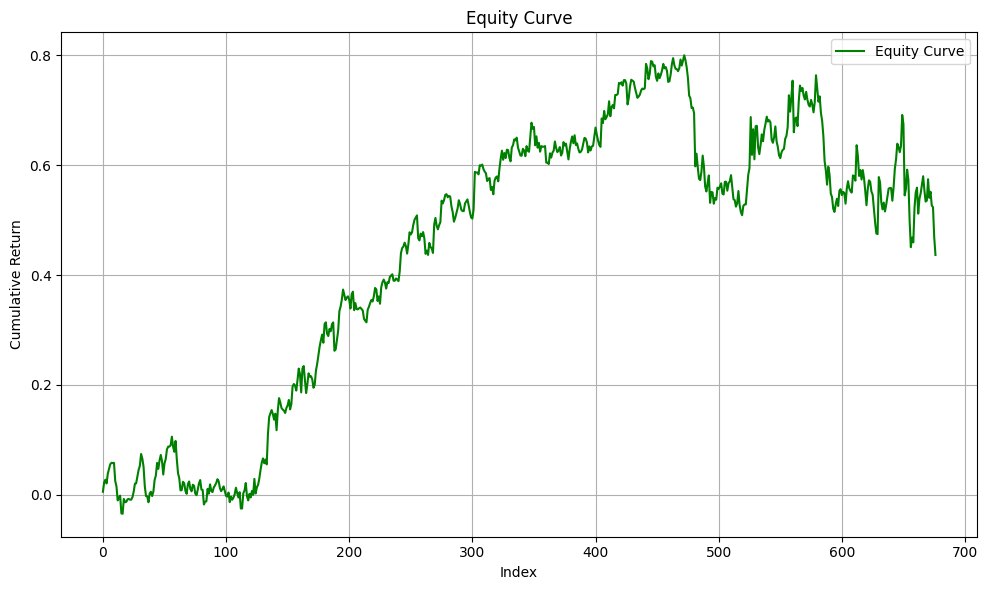

In [260]:
# Wykres equity_curve
plt.figure(figsize=(10, 6))
plt.plot(trade_results['equity_curve'], label='Equity Curve', color='green')
plt.xlabel('Index')
plt.ylabel('Cumulative Return')
plt.title('Equity Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [264]:
maker_fee = 0.0001
taker_fee = 0.003

roundtrip_fee_log = np.log(1 -2 * taker_fee)

trade_results = trade_results.with_columns(pl.lit(roundtrip_fee_log).alias('tx_fee_log'))
trade_results = trade_results.with_columns((pl.col('trade_log_return') + pl.col('tx_fee_log')).alias('trade_log_return_net'))
trade_results = trade_results.with_columns(pl.col('trade_log_return_net').cum_sum().alias('equity_curve_net'))

trade_results

y_hat,y,is_won,signal,trade_log_return,equity_curve,tx_fee_log,trade_log_return_net,equity_curve_net
f32,f32,bool,f32,f32,f32,f64,f64,f64
0.002046,0.005721,true,1.0,0.005721,0.005721,-0.006018,-0.000297,-0.000297
0.000277,0.016965,true,1.0,0.016965,0.022686,-0.006018,0.010947,0.01065
-0.002925,-0.004997,true,-1.0,0.004997,0.027683,-0.006018,-0.001022,0.009629
-0.000024,0.006864,false,-1.0,-0.006864,0.020818,-0.006018,-0.012883,-0.003254
-0.000905,-0.018199,true,-1.0,0.018199,0.039017,-0.006018,0.012181,0.008927
…,…,…,…,…,…,…,…,…
0.012192,0.011111,true,1.0,0.011111,0.551614,-0.006018,0.005093,-3.498549
0.004937,-0.025176,false,1.0,-0.025176,0.526437,-0.006018,-0.031194,-3.529744
0.007508,-0.002837,false,1.0,-0.002837,0.523601,-0.006018,-0.008855,-3.538598


In [265]:
trade_results['is_won'].mean()

0.5125553914327917

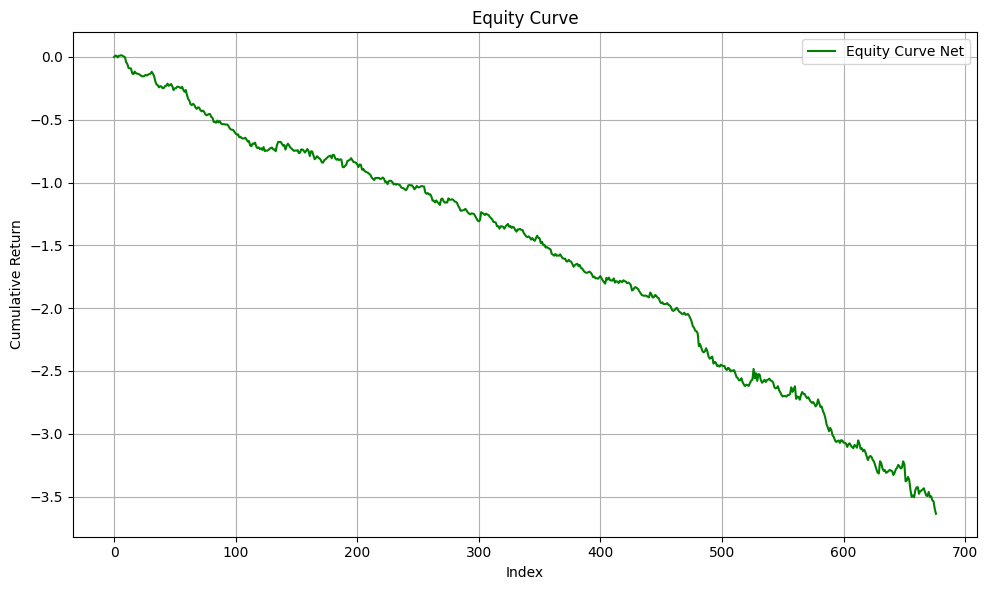

In [266]:
plt.figure(figsize=(10, 6))
plt.plot(trade_results['equity_curve_net'], label='Equity Curve Net', color='green')
plt.xlabel('Index')
plt.ylabel('Cumulative Return')
plt.title('Equity Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()